# Recurrent Neural Networks (RNN) — Time Series Prediction

In this notebook we will explore Recurrent Neural Networks (RNNs), a type of neural network designed for working with sequential data. Unlike feed-forward networks that treat inputs independently, RNNs have "memory" which allows them to process sequences while taking previous inputs into account.

We will focus on **LSTM (Long Short-Term Memory)** layers, a popular type of RNN, and use them for a simple **time series prediction** task.

## Objectives
* Understand the need for RNNs when working with sequential data.
* Learn how to prepare sequential data for RNNs using the sliding window approach.
* Build and train a simple LSTM model for time series prediction.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


## 1. Generating synthetic time series

We create a simple sinusoidal time series with added noise. This will be our dataset for training and testing.

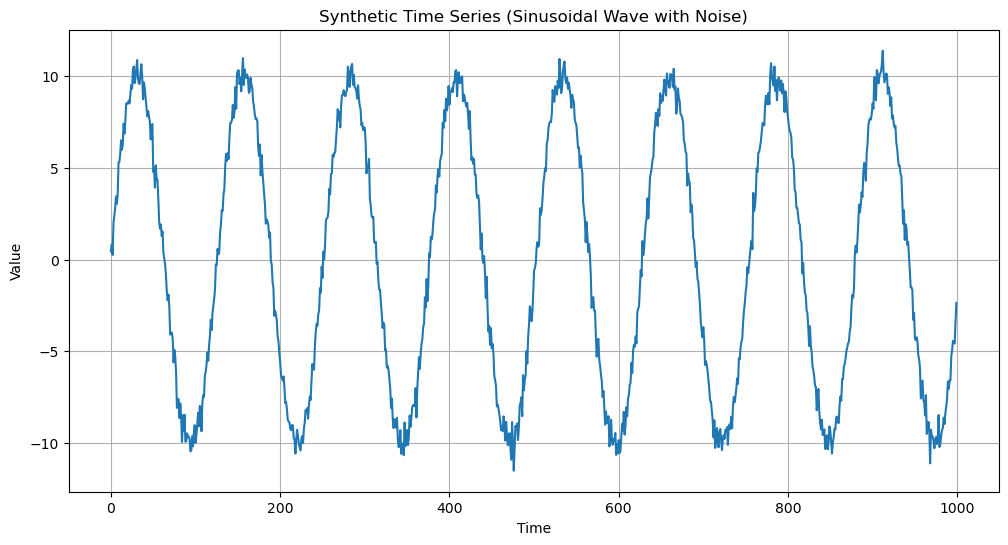

In [2]:
# Series parameters
timesteps_total = 1000
amplitude = 10
frequency = 0.05
noise_std = 0.5

# Generating X (time points)
time = np.arange(timesteps_total)

# Generating Y (sinusoidal value with noise)
data = amplitude * np.sin(frequency * time) + np.random.normal(0, noise_std, timesteps_total)

plt.figure(figsize=(12, 6))
plt.plot(time, data)
plt.title('Synthetic Time Series (Sinusoidal Wave with Noise)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## 2. Preparing data for RNN

RNNs require inputs in a specific format: `(num_samples, timesteps_per_sequence, num_features)`.  
For time series prediction, we use the sliding window approach:
- Each input sample (`X`) is a sequence of the previous `n_steps` values.
- The corresponding output (`y`) is the next value following that sequence.

Note: In this notebook `n_steps` is used when creating sequences and `X` is reshaped to `(num_samples, n_steps, 1)` because there is a single feature per timestep. Also, when splitting data, use a chronological (non-random) split.

In [3]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        # X is a sequence of the previous n_steps values
        X.append(data[i:(i + n_steps)])
        # y is the next value in the series
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# Number of steps in the sequence that the model looks at before predicting the next value
n_steps = 10 

X, y = create_sequences(data, n_steps)

print(f"Original data shape: {data.shape}")
print(f"X (sequences) shape: {X.shape}") # (number_of_samples, n_steps)
print(f"y (outputs) shape: {y.shape}")   # (number_of_samples)

# RNN layers expect 3D input: (number_of_samples, number_of_steps_in_sequence, number_of_features)
# Here we have only one feature per step (one value), so we add a features dimension.
X = X.reshape(X.shape[0], X.shape[1], 1)

print(f"X (sequences) shape for LSTM: {X.shape}") # (number_of_samples, n_steps, 1)

# Splitting into training and test sets
# Important: For time series, we do not use random split, but split chronologically
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Original data shape: (1000,)
X (sequences) shape: (990, 10)
y (outputs) shape: (990,)
X (sequences) shape for LSTM: (990, 10, 1)
X_train shape: (792, 10, 1)
y_train shape: (792,)
X_test shape: (198, 10, 1)
y_test shape: (198,)


## 3. Building the LSTM model

We will create a simple model with a single LSTM layer followed by a Dense output layer (predicting one continuous value).

- `LSTM(units=50)`: 50 units in the LSTM layer. `input_shape=(n_steps, 1)` defines the shape of the input sequence (10 steps, 1 feature per step).
- `Dense(1)`: Output layer with a single neuron, since we predict one numeric value.

In [4]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, 1)),
    Dense(1) # The output is a single numerical value
])

model.compile(optimizer='adam', loss='mse') # Using Mean Squared Error for regression

model.summary()

C:\Users\Windows 10\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Training the model

We train the model using the training data (see the following cell for the model.fit call and training history).

In [6]:
history = model.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test))

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 28.5465 - val_loss: 6.9520
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4308 - val_loss: 3.6229
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3262 - val_loss: 1.9685
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9065 - val_loss: 1.3009
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2750 - val_loss: 0.8766
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9944 - val_loss: 0.6688
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5675 - val_loss: 0.5047
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4514 - val_loss: 0.3937
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4390 - val_loss: 0.3300
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3920 - val_loss: 0.3656
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3886 - val_loss: 0.3427
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0

## 5. Visualization of Training History

Plot the training and validation loss over epochs to inspect how the model's error evolved during training.

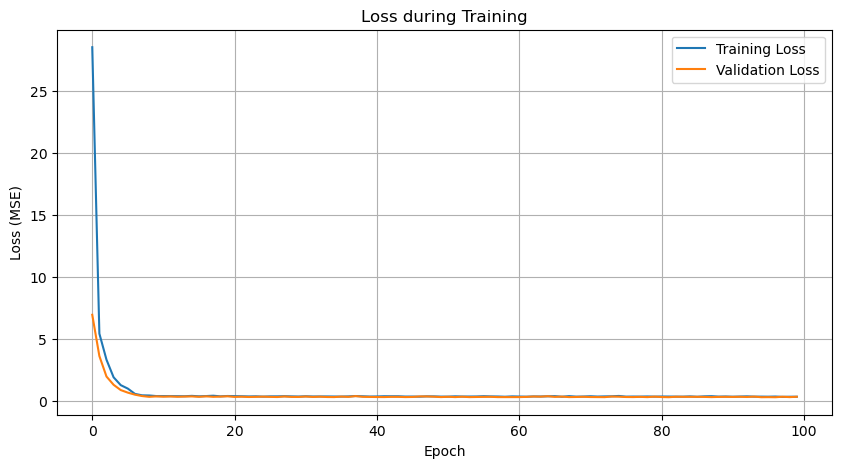

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 6. Prediction and visualization of results

Now we will use the trained model to make predictions on the entire time series and compare them with the actual values.

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


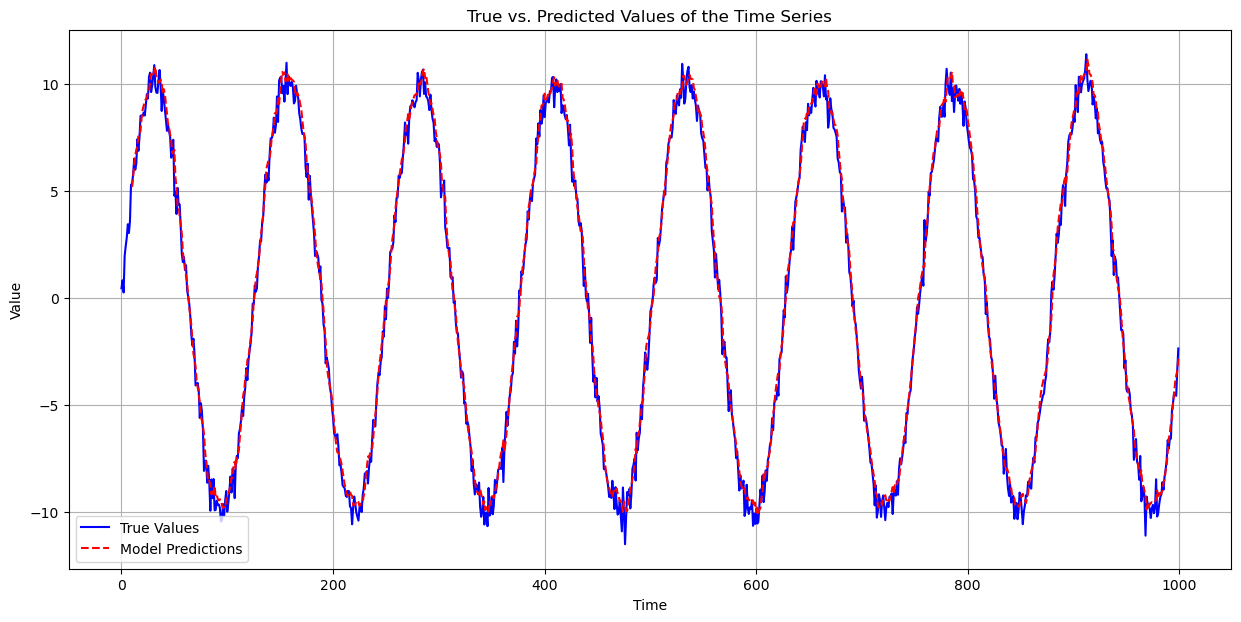

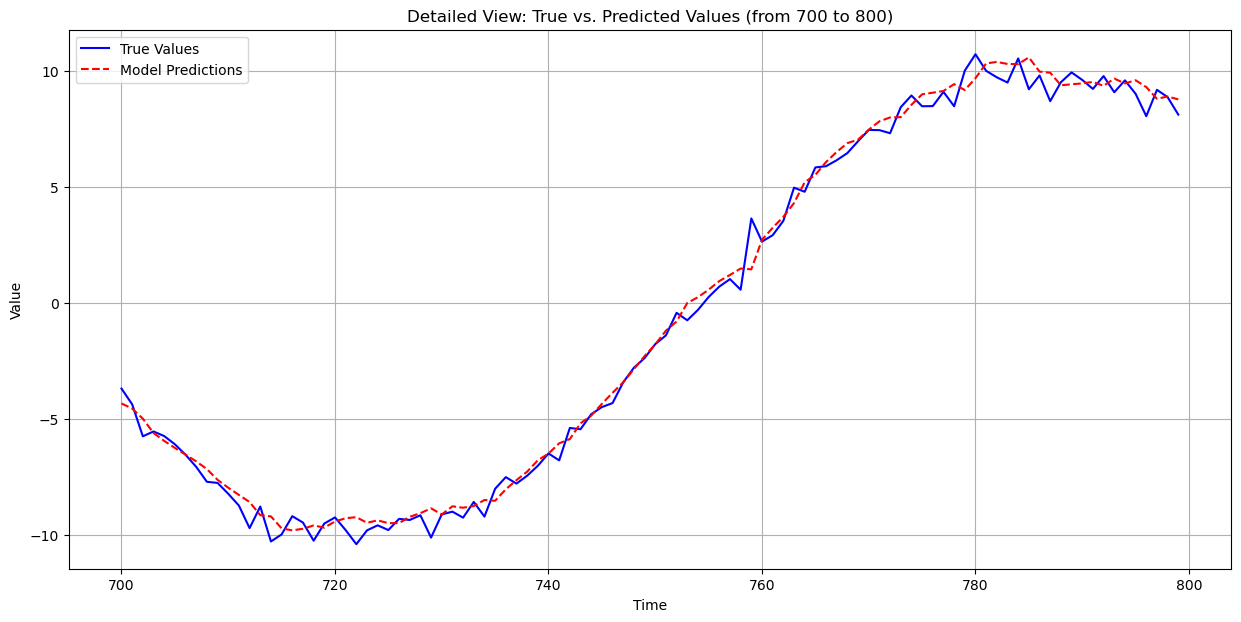

In [8]:
# Make predictions on the entire dataset (except the first n_steps)
y_pred = model.predict(X)

plt.figure(figsize=(15, 7))
plt.plot(time, data, label='True Values', color='blue')

# We shift the predicted values by n_steps to align with y
plt.plot(time[n_steps:], y_pred, label='Model Predictions', color='red', linestyle='--')

plt.title('True vs. Predicted Values of the Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Detailed view of a segment of the series
start_idx = 700 # Starting from index 700 to see how the model generalizes to newer data
end_idx = 800

plt.figure(figsize=(15, 7))
plt.plot(time[start_idx:end_idx], data[start_idx:end_idx], label='True Values', color='blue')
plt.plot(time[start_idx:end_idx], y_pred[start_idx - n_steps:end_idx - n_steps], label='Model Predictions', color='red', linestyle='--')

plt.title(f'Detailed View: True vs. Predicted Values (from {start_idx} to {end_idx})')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## Try training your own model now

**Ideas for experimentation:**
* Change `n_steps` (window size) when creating sequences.
* Change the number of `LSTM` units (`units`).
* Add more `LSTM` layers (if you add more LSTM layers, all but the last must have `return_sequences=True`).
    ```python
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(n_steps, 1), return_sequences=True),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    ```
* Change the number of `epochs`.
* Experiment with different activation functions.
* Add noise or change the frequency and amplitude in the generated data.